In [1]:
import yt
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib as mpl

yt.set_log_level("error")
mpl.rcParams["font.family"] = "serif"
mpl.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams["text.usetex"] = True
mpl.rcParams["lines.linewidth"] = 1
mpl.rcParams["lines.markersize"] = 3.5
mpl.rcParams["xtick.direction"] = "out"
mpl.rcParams["ytick.direction"] = "out"
mpl.rcParams["xtick.major.size"] = 2
mpl.rcParams["ytick.major.size"] = 2
mpl.rcParams["legend.frameon"] = False
mpl.rcParams["legend.fontsize"] = "small"

/home/bendp/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
def format_axes(ax, xlab):
    ax[0,0].set_xlabel(xlab)
    ax[0,1].set_xlabel(xlab)
    ax[1,0].set_xlabel(xlab)
    ax[1,1].set_xlabel(xlab)

    ax[0,0].legend()
    ax[0,1].legend()
    ax[1,0].legend()
    ax[1,1].legend()

    ax[0,0].set_ylabel("Density, $\\rho$")
    ax[0,1].set_ylabel("Velocity, $v$")
    ax[1,0].set_ylabel("Pressure, $p$")
    ax[1,1].set_ylabel("Specific internal energy, $\epsilon$")

def get_ray(adiabatic, rot, dim, ds):
    rot = np.deg2rad(rot)
    fields = ["x", "density", "mom_x", "energy"]
    if dim >= 2:
        fields.append("y")
        fields.append("mom_y")
    if dim >= 3:
        fields.append("z")
        fields.append("mom_z")
    if dim == 1:
        ray = ds.ray([ds.domain_left_edge[0].value,0,0], [ds.domain_right_edge[0].value,0,0]).to_dataframe(fields)
    else:
        ray = ds.ray([0, 0.5 - 0.5*np.tan(rot), 0], [1, 0.5 + 0.5*np.tan(rot), 0]).to_dataframe(fields)
    size = np.array(ray["x"]).size
    if (dim < 2):
        ray["mom_y"] = np.zeros(size)
        ray["y"] = np.zeros(size)
    if (dim < 3):
       ray["mom_z"] = np.zeros(size)
       ray["z"] = np.zeros(size)

    if (dim == 1):
        ray["d"] = ray["x"]
    else:
        ray["d"] = (ray["x"] - 0.5)*np.cos(rot) + (ray["y"] - 0.5)*np.sin(rot) + 0.5
    ray["mom"] = np.sqrt(ray["mom_x"] * ray["mom_x"] + ray["mom_y"] * ray["mom_y"] + ray["mom_z"] * ray["mom_z"])
    ray["vel"] = ray["mom"] / ray["density"] * np.sign(ray["mom_x"])
    ray["int_energy"] = (ray["energy"] - 0.5 * ray["mom"] * ray["mom"] / ray["density"]) / ray["density"]
    ray["pressure"] = (adiabatic - 1) * ray["density"] * ray["int_energy"]
    return ray


def plot_four(ray, ax, fmt, label, **kwargs):    
    ax[0,0].plot(ray["d"],ray["density"],fmt,label=label, **kwargs)
    ax[0,1].plot(ray["d"],ray["vel"],fmt,label=label, **kwargs)
    ax[1,0].plot(ray["d"],ray["pressure"],fmt,label=label, **kwargs)
    ax[1,1].plot(ray["d"],ray["int_energy"],fmt,label=label, **kwargs)

# Live plots
## 1D tests

/tmp/ipykernel_249999/1804794419.py:54: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_249999/1804794419.py:54: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_249999/1804794419.py:54: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_249999/1804794419.py:54: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_249999/1804794419.py:54: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_249999/1804794419.py:54: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


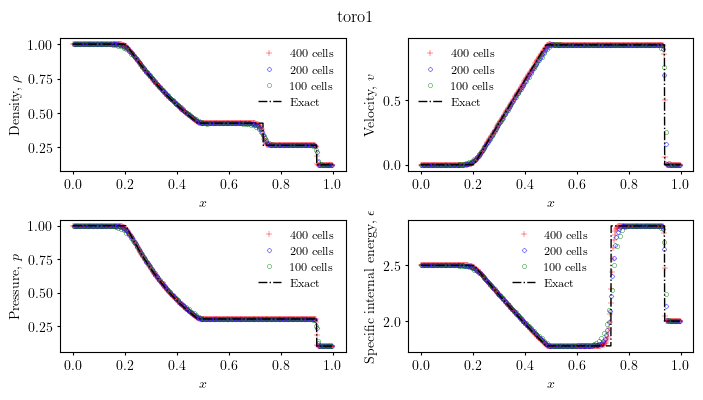

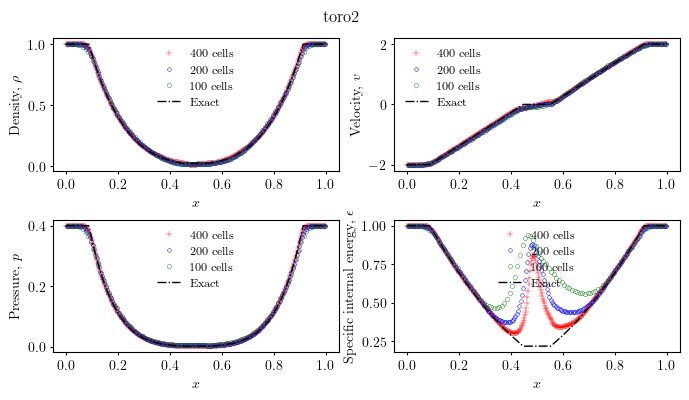

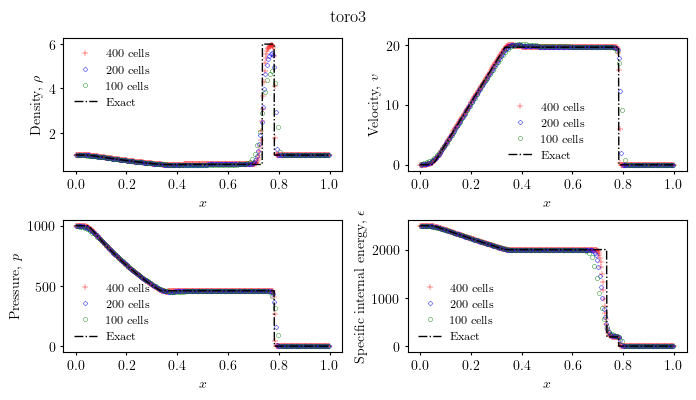

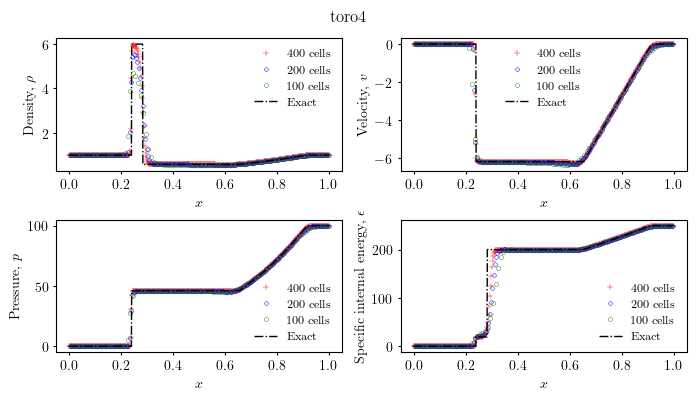

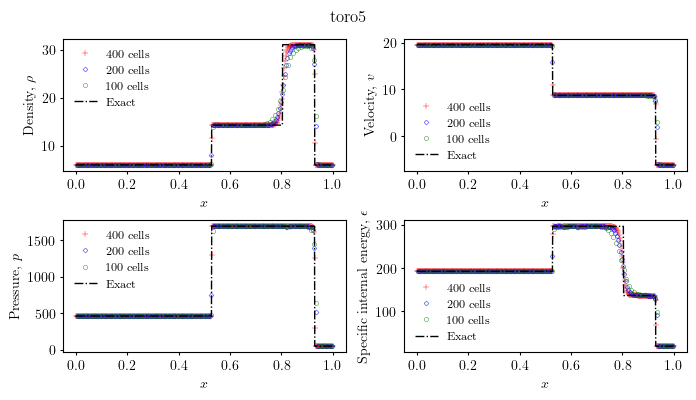

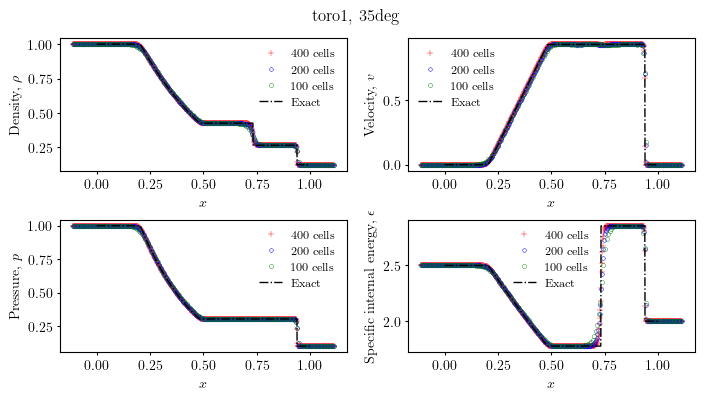

In [5]:
DIRECTORIES = ["build/Exec/RiemannProblem/output/test1/*",
               "build/Exec/RiemannProblem/output/test2/*",
               "build/Exec/RiemannProblem/output/test3/*",
               "build/Exec/RiemannProblem/output/test4/*",
               "build/Exec/RiemannProblem/output/test5/*",
               "build/Exec/RiemannProblem2D/output/test1/35deg/*"]

EXACT_SOLN_EXISTS = [True, True, True, True, True, True]
NAMES = ["toro1", "toro2", "toro3", "toro4", "toro5", "toro1, 35deg"]
ADIABATICS = [1.4, 1.4, 1.4, 1.4, 1.4, 1.4]
DIMS = [1, 1, 1, 1, 1, 2]
ROTS = [0, 0, 0, 0, 0, 35]

exact_fmt = "k-."
res_fmts = ["go", "bD", "r+"]
marker_sizes = [3, 2.5, 4]

tests_to_plot = [0,1,2,3,4,5]

for i in tests_to_plot:
    TESTCASE = DIRECTORIES[i]
    SUBRUN_DIRS = sorted(glob.glob(TESTCASE))
    SUBRUN_FINAL_OUTPUTS = [sorted(glob.glob(SUBRUN_DIR+"/plt?????"))[-1] for SUBRUN_DIR in SUBRUN_DIRS]
    EXACT_SOLUTION = SUBRUN_DIRS[0] + "/pltEXACT_SOLN"
    adiabatic = ADIABATICS[i]
    dim = DIMS[i]
    rot = ROTS[i]
    fig, ax = plt.subplots(2, 2, figsize=(7,4))

    fig.suptitle(NAMES[i])

    # plot numerical solution
    for ifile, plotfile in reversed(list(enumerate(SUBRUN_FINAL_OUTPUTS))):
        ds = yt.load(plotfile)
        label = f"{ds.domain_dimensions[0]} cells"

        # ray
        ray = get_ray(adiabatic, rot, dim, ds)
        plot_four(ray,ax,res_fmts[ifile],label,markersize = marker_sizes[ifile], fillstyle="none", markeredgewidth=0.3)

    # plot exact solution
    if (EXACT_SOLN_EXISTS[i]):
        label = "Exact"
        ds = yt.load(EXACT_SOLUTION)
        ray = get_ray(adiabatic, 0, 1, ds)
        plot_four(ray,ax,exact_fmt,label)

    # make plots pretty
    xlab = "$x$"
    format_axes(ax, xlab)

    fig.tight_layout(pad=0.8)
    # fig.savefig(f"outputs/{NAMES[i]}.svg", dpi=300)
    fig.show()

## 1D tests with output at every time

In [9]:
BASE_FILENAMES = ["./build/Exec/RiemannProblem/output/test1/100/plt",
             "./build/Exec/RiemannProblem/output/test2/100/plt",
             "./build/Exec/RiemannProblem/output/test3/100/plt",
             "./build/Exec/RiemannProblem/output/test4/100/plt",
             "./build/Exec/RiemannProblem/output/test5/100/plt"]
FILENAMES = [filename + "?????" for filename in BASE_FILENAMES]
EXACT_SOLN_FILENAMES = [filename + "EXACT_SOLN" for filename in BASE_FILENAMES]

adiabatic = 1.4

/tmp/ipykernel_179386/4259237909.py:77: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


FileNotFoundError: No match found for pattern : ./build/Exec/RiemannProblem/output/test2/100/plt?????

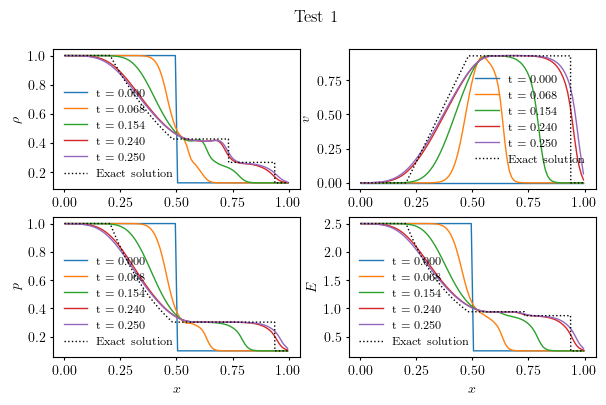

In [13]:
yt.set_log_level("error")
DIM = 1
to_plot = [0,1,2,3,4]
for i in to_plot:
    FILENAME = FILENAMES[i]
    ts = yt.load(FILENAME)

    fig,ax = plt.subplots(2,2, figsize=(7,4))
    for ds in ts:
        if DIM == 1:
            ray = ds.ray([ds.domain_left_edge[0].value,0,0], [ds.domain_right_edge[0].value,0,0])
            mom = np.array(ray["mom_x"])
            x = np.array(ray["x"])
        else:
            x_centre = (ds.domain_left_edge[0].value + ds.domain_right_edge[0].value)/2
            ray = ds.ray([x_centre,ds.domain_left_edge[1].value,0], [x_centre,ds.domain_right_edge[1].value,0])
            mom = np.array(ray["mom_y"])
            x = np.array(ray["y"])
        time_label = f"t = {ds.current_time.value:.3f}"
        # time_label = f"Numerical Solution, {len(x)} cells"
        density = np.array(ray["density"])
        energy = np.array(ray["energy"])
        vel_x = mom / density
        pressure = (adiabatic - 1)*(energy - 0.5*density*np.power(vel_x,2))
            
        # print(density)
        # num_fmt = "bx"
        num_fmt = ""
        ax[0,0].plot(x,density,num_fmt,label=time_label)
        ax[0,1].plot(x,vel_x,num_fmt,label=time_label)
        ax[1,0].plot(x,pressure,num_fmt,label=time_label)
        ax[1,1].plot(x,energy,num_fmt,label=time_label)

    #
    # Plot exact solution
    #
    exact = yt.load(EXACT_SOLN_FILENAMES[i])
    ray = exact.ray([exact.domain_left_edge[0].value,0,0], [exact.domain_right_edge[0].value,0,0])
    mom = np.array(ray["mom_x"])
    x = np.array(ray["x"])
    density = np.array(ray["density"])
    energy = np.array(ray["energy"])
    vel_x = mom / density
    pressure = (adiabatic - 1)*(energy - 0.5*density*np.power(vel_x,2))
        
    exact_label = "Exact solution"
    exact_fmt = "k:"

    ax[0,0].plot(x,density,exact_fmt,label=exact_label)
    ax[0,1].plot(x,vel_x,exact_fmt,label=exact_label)
    ax[1,0].plot(x,pressure,exact_fmt,label=exact_label)
    ax[1,1].plot(x,energy,exact_fmt,label=exact_label)


    ax[0,0].set_ylabel("$\\rho$")
    ax[0,1].set_ylabel("$v$")
    ax[1,0].set_ylabel("$p$")
    ax[1,1].set_ylabel("$E$")

    if DIM == 1:
        x_label = "$x$"
    else:
        x_label = "$y$"

    ax[0,0].set_xlabel(x_label)
    ax[0,1].set_xlabel(x_label)
    ax[1,0].set_xlabel(x_label)
    ax[1,1].set_xlabel(x_label)

    ax[0,0].legend()
    ax[0,1].legend()
    ax[1,0].legend()
    ax[1,1].legend()

    fig.suptitle(f"Test {i+1}")

    fig.show()

## Cylindrical Explosion

/tmp/ipykernel_21379/648381014.py:87: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


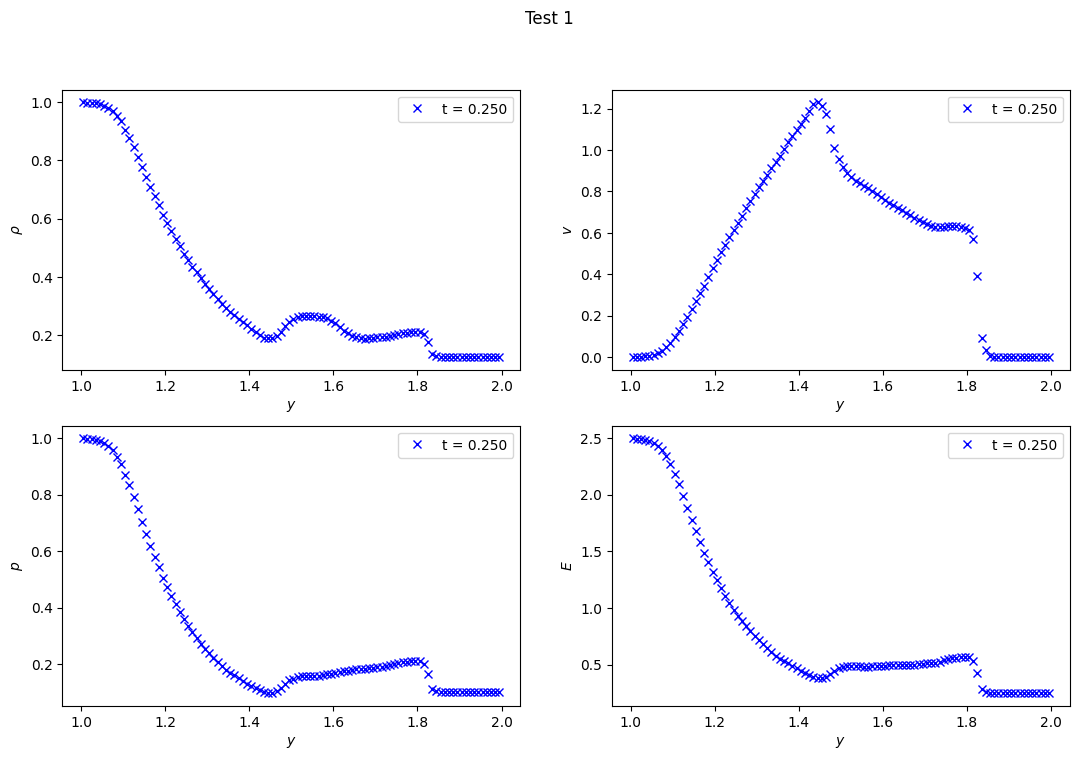

In [25]:
# BASE_FILENAMES = ["./outputs/cylindricalexplosion_200_3d/plt"]
# FILENAMES = [filename + "?????" for filename in BASE_FILENAMES]
FILENAMES = ["./outputs/cylindricalexplosion_200_3d/plt00065"]
# EXACT_SOLN_FILENAMES = [filename + "EXACT_SOLN" for filename in BASE_FILENAMES]

adiabatic = 1.4

yt.set_log_level("error")
DIM = 2
to_plot = [0]
for i in to_plot:
    FILENAME = FILENAMES[i]
    ts = yt.load(FILENAME)

    fig,ax = plt.subplots(2,2, figsize=(13,8))
    # for ds in ts[-2:-1]:
    for ds in [ts]:
        if DIM == 1:
            ray = ds.ray([ds.domain_left_edge[0].value,0,0], [ds.domain_right_edge[0].value,0,0])
            mom = np.array(ray["mom_x"])
            x = np.array(ray["x"])
        else:
            x_centre = (ds.domain_left_edge[0].value + ds.domain_right_edge[0].value)/2
            y_centre = (ds.domain_left_edge[1].value + ds.domain_right_edge[1].value)/2
            z_centre = (ds.domain_left_edge[2].value + ds.domain_right_edge[2].value)/2
            ray = ds.ray([x_centre,y_centre,z_centre], [x_centre,ds.domain_right_edge[1].value,z_centre])
            mom = np.array(ray["mom_y"])
            x = np.array(ray["y"])
        time_label = f"t = {ds.current_time.value:.3f}"
        # time_label = f"Numerical Solution, {len(x)} cells"
        density = np.array(ray["density"])
        energy = np.array(ray["energy"])
        vel_x = mom / density
        pressure = (adiabatic - 1)*(energy - 0.5*density*np.power(vel_x,2))
            
        # print(density)
        # num_fmt = "bx"
        num_fmt = "bx"
        ax[0,0].plot(x,density,num_fmt,label=time_label)
        ax[0,1].plot(x,vel_x,num_fmt,label=time_label)
        ax[1,0].plot(x,pressure,num_fmt,label=time_label)
        ax[1,1].plot(x,energy,num_fmt,label=time_label)

    # #
    # # Plot exact solution
    # #
    # exact = yt.load(EXACT_SOLN_FILENAMES[i])
    # ray = exact.ray([exact.domain_left_edge[0].value,0,0], [exact.domain_right_edge[0].value,0,0])
    # mom = np.array(ray["mom_x"])
    # x = np.array(ray["x"])
    # density = np.array(ray["density"])
    # energy = np.array(ray["energy"])
    # vel_x = mom / density
    # pressure = (adiabatic - 1)*(energy - 0.5*density*np.power(vel_x,2))
        
    # exact_label = "Exact solution"
    # exact_fmt = "k:"

    # ax[0,0].plot(x,density,exact_fmt,label=exact_label)
    # ax[0,1].plot(x,vel_x,exact_fmt,label=exact_label)
    # ax[1,0].plot(x,pressure,exact_fmt,label=exact_label)
    # ax[1,1].plot(x,energy,exact_fmt,label=exact_label)


    ax[0,0].set_ylabel("$\\rho$")
    ax[0,1].set_ylabel("$v$")
    ax[1,0].set_ylabel("$p$")
    ax[1,1].set_ylabel("$E$")

    if DIM == 1:
        x_label = "$x$"
    else:
        x_label = "$y$"

    ax[0,0].set_xlabel(x_label)
    ax[0,1].set_xlabel(x_label)
    ax[1,0].set_xlabel(x_label)
    ax[1,1].set_xlabel(x_label)

    ax[0,0].legend()
    ax[0,1].legend()
    ax[1,0].legend()
    ax[1,1].legend()

    fig.suptitle(f"Test {i+1}")

    fig.show()

# Plotting existing results

/tmp/ipykernel_21379/4294276362.py:90: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


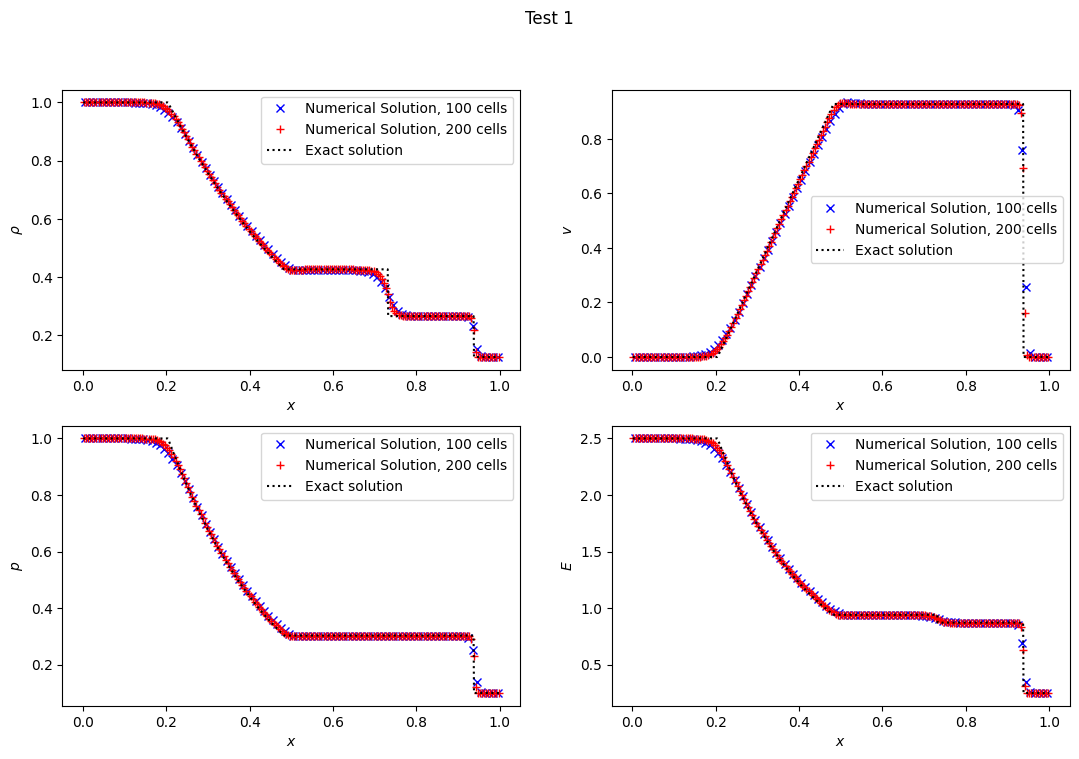

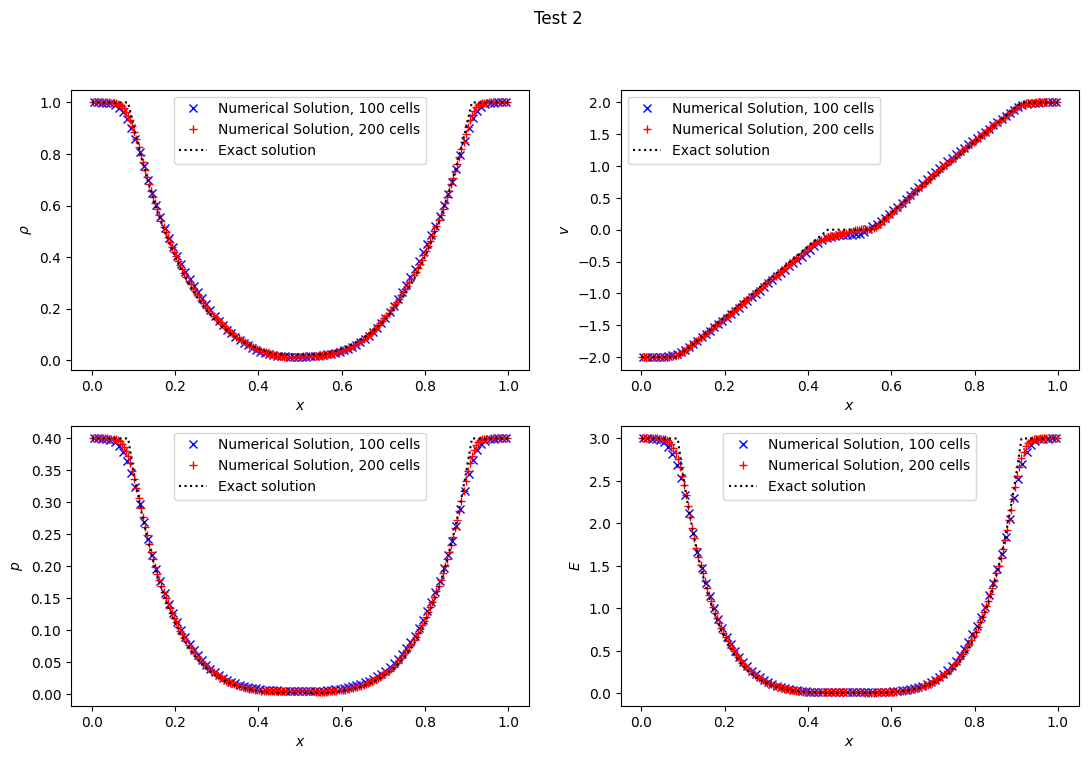

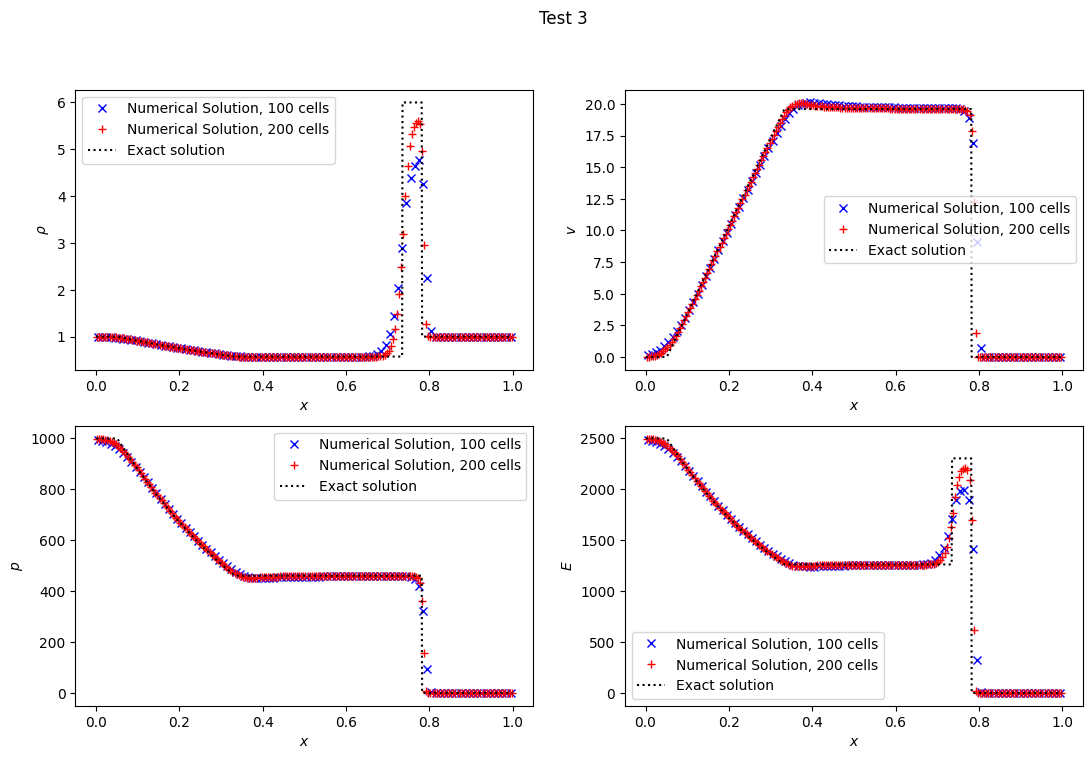

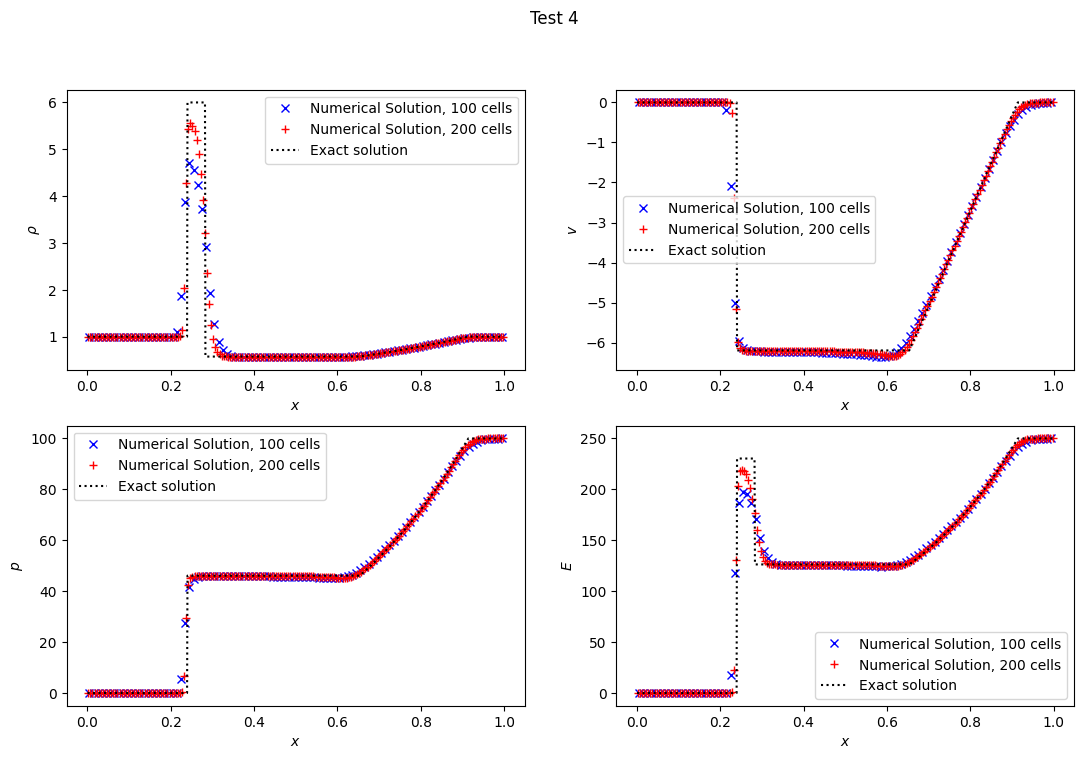

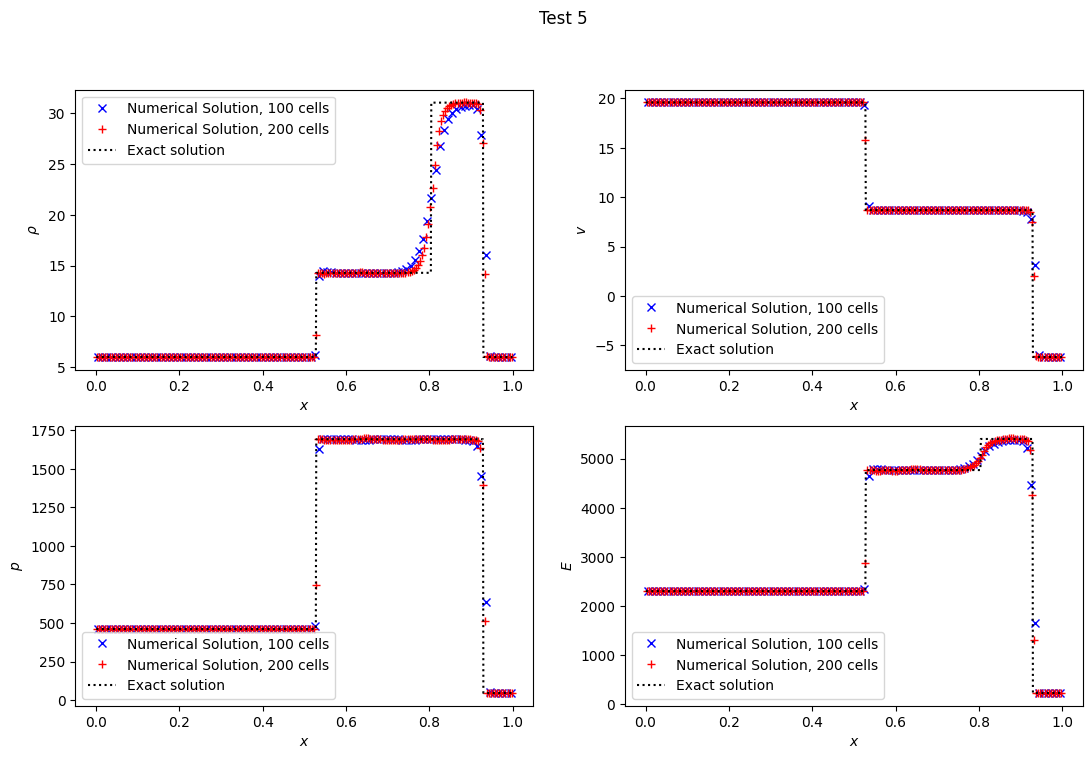

In [16]:
BASE_FILENAMES = [["./outputs/toro/muscl_hancock_100/test1/plt", "./outputs/toro/muscl_hancock_200/test1/plt"],
                  ["./outputs/toro/muscl_hancock_100/test2/plt", "./outputs/toro/muscl_hancock_200/test2/plt"],
                  ["./outputs/toro/muscl_hancock_100/test3/plt", "./outputs/toro/muscl_hancock_200/test3/plt"],
                  ["./outputs/toro/muscl_hancock_100/test4/plt", "./outputs/toro/muscl_hancock_200/test4/plt"],
                  ["./outputs/toro/muscl_hancock_100/test5/plt", "./outputs/toro/muscl_hancock_200/test5/plt"]]
FILENAMES = [[filename + "?????" for filename in subcase] for subcase in BASE_FILENAMES]
EXACT_SOLN_FILENAMES = [subcase[0] + "EXACT_SOLN" for subcase in BASE_FILENAMES]

adiabatic = 1.4

yt.set_log_level("error")
DIM = 1
to_plot = [0,1,2,3,4]
num_fmts = ["bx", "r+"]
for i in to_plot:
    subcase = FILENAMES[i]
    last_timestep_cases = []
    for FILENAME in subcase:
        ts = yt.load(FILENAME)
        last_timestep_cases.append(ts[-1])

    fig,ax = plt.subplots(2,2, figsize=(13,8))
    for subcase_no, ds in enumerate(last_timestep_cases):
        if DIM == 1:
            ray = ds.ray([ds.domain_left_edge[0].value,0,0], [ds.domain_right_edge[0].value,0,0])
            mom = np.array(ray["mom_x"])
            x = np.array(ray["x"])
        else:
            x_centre = (ds.domain_left_edge[0].value + ds.domain_right_edge[0].value)/2
            ray = ds.ray([x_centre,ds.domain_left_edge[1].value,0], [x_centre,ds.domain_right_edge[1].value,0])
            mom = np.array(ray["mom_y"])
            x = np.array(ray["y"])
        # time_label = f"t = {ds.current_time.value:.3f}"
        time_label = f"Numerical Solution, {len(x)} cells"
        density = np.array(ray["density"])
        energy = np.array(ray["energy"])
        vel_x = mom / density
        pressure = (adiabatic - 1)*(energy - 0.5*density*np.power(vel_x,2))
            
        # print(density)
        num_fmt = num_fmts[subcase_no]
        ax[0,0].plot(x,density,num_fmt,label=time_label)
        ax[0,1].plot(x,vel_x,num_fmt,label=time_label)
        ax[1,0].plot(x,pressure,num_fmt,label=time_label)
        ax[1,1].plot(x,energy,num_fmt,label=time_label)

    #
    # Plot exact solution
    #
    exact = yt.load(EXACT_SOLN_FILENAMES[i])
    ray = exact.ray([exact.domain_left_edge[0].value,0,0], [exact.domain_right_edge[0].value,0,0])
    mom = np.array(ray["mom_x"])
    x = np.array(ray["x"])
    density = np.array(ray["density"])
    energy = np.array(ray["energy"])
    vel_x = mom / density
    pressure = (adiabatic - 1)*(energy - 0.5*density*np.power(vel_x,2))
        
    exact_label = "Exact solution"
    exact_fmt = "k:"

    ax[0,0].plot(x,density,exact_fmt,label=exact_label)
    ax[0,1].plot(x,vel_x,exact_fmt,label=exact_label)
    ax[1,0].plot(x,pressure,exact_fmt,label=exact_label)
    ax[1,1].plot(x,energy,exact_fmt,label=exact_label)


    ax[0,0].set_ylabel("$\\rho$")
    ax[0,1].set_ylabel("$v$")
    ax[1,0].set_ylabel("$p$")
    ax[1,1].set_ylabel("$E$")

    if DIM == 1:
        x_label = "$x$"
    else:
        x_label = "$y$"

    ax[0,0].set_xlabel(x_label)
    ax[0,1].set_xlabel(x_label)
    ax[1,0].set_xlabel(x_label)
    ax[1,1].set_xlabel(x_label)

    ax[0,0].legend()
    ax[0,1].legend()
    ax[1,0].legend()
    ax[1,1].legend()

    fig.suptitle(f"Test {i+1}")

    fig.show()